# Enrichment procedure on missing data via clustering-based classification

_Note to reader: You're currently reading the main work of a single contributor. I highly recommend visiting [Matt's](https://github.com/mc17336/DST-Assessment-2/tree/main/Matt%20Corrie) and [Wenqi's](https://github.com/mc17336/DST-Assessment-2/tree/main/Wenqi%20Fang) work after reading this file. Thank you!_

In this project my colleagues and I tackle the issue of reconstructing, to the best of our abilities, missing data in a specific framework. To this extent, we aim to make great use of the rest of the dataset in order to classify datapoints and detect potential dependencies which would help us understand the nature of our missing data. For this procedure we considered clustering on features found to be relevant in order to algorithmically classify the data in a fashion suited for re-insertion of the datapoints that were missing. The (relative) success of this process is mostly due to the nature of our dataset, as data was not missing completely at random, and in fact was only numerically missing in 3 key features.

We considered **K-means clustering** as a basic model for clustering, and hence expected it to perform quite well, but be outperformed by a more complex method. This secondary, non-trivial model we considered was **DBScan clustering**, which was meant to reconstruct missingness with more nuance than the basic model. However, the results were counterintuitive to us. In this paper (and this only) we take a brief look at how we could've gone about using clustering for other procedures, specifically for detecting intrusion. This part of the project is split as follows:

1) Data reading and data cleansing

2) Is our dataset "cherry-picked"?

3) 2/4 ways to deal with NAs

4) K-means clustering - 2 attempts

5) Using our best cluster to reconstruct the missing data

6) Conclusions

7) A bit about intrusion*

Before anything else, the following packages are required for the project:

In [41]:
# install.packages("class")
library(class)  
# install.packages("Matrix")
library(Matrix)
# install.packages("irlba") 
library(irlba)    
# install.packages("Rtsne")   
library(Rtsne) 
# install.packages("fpc")
library(fpc)
# install.packages("knitr")
library(knitr)

## Data reading and data cleansing

**Obtaining the data:** The data was obtained from [here](www.secrepo.com), under conn.log. However, it was far too large to work with. We had to separate a subset of the data to work with, and distinguished between two options: Either _sampling_ the data - where we have the advantage of massively increasing the chances of adequately capturing what the whole data looks like, and the disadvantage of losing the possibility to perform time-series analysis; OR _extracting_ - where the pros and cons are reversed. Due to our inquiry's goal, we decided sampling is preferable.

The data we'll be using throughout this paper is found [here](https://github.com/mc17336/DST-Assessment-2/blob/main/Data/MAC.zip) and it must be downloaded accordingly. The way the data was obtained is documented and can be found [here](https://github.com/mc17336/DST-Assessment-2/blob/main/Data/Code_for_obtaining_data.ipynb) - but the reader is asked to carefully read through all indications, as to not run the code where not needed and risk compromising their ability to run the project.

Once the data has been saved as "MAC.csv", we can begin the reading:

In [2]:
setwd("D://R-4.0.2//ExcelWorks")  ## Change this with the work directory where YOU saved the file as "Mac.csv"
data<- read.csv(file = "MAC.csv", header = T)
head(data, 50)

X,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
5813043,1331908160,CHEoFb1O6PBGt1NEa7,192.168.202.110,50427,192.168.22.102,15457,tcp,-,NA,NA,NA,REJ,NA,0,Sr,1,48,1,40
11476450,1331928816,Cy6Fv76vPYfgHtCpk,192.168.202.83,46442,192.168.206.44,42,tcp,-,NA,NA,NA,REJ,NA,0,Sr,1,60,1,40
5486523,1331907968,CkpLOHhJomkmlfso3,192.168.202.110,12662,192.168.22.1,17800,tcp,-,NA,NA,NA,S0,NA,0,S,1,48,0,0
18708180,1332000495,CMQ0Qy4XI18ermMFhb,192.168.202.138,35203,192.168.24.187,10629,tcp,-,NA,NA,NA,S0,NA,0,S,1,44,0,0
6090879,1331908285,CiCXbo2GSUPiqsv2Kl,192.168.202.110,63958,192.168.22.252,56587,tcp,-,NA,NA,NA,S0,NA,0,S,1,48,0,0
1700487,1331903789,C5SBk532nTOCbdcXWf,192.168.204.45,39436,192.168.21.101,33384,tcp,-,NA,NA,NA,REJ,NA,0,Sr,1,44,1,40
4530835,1331905416,Cvtgnu3rcNc9OE5F0g,192.168.202.83,52132,192.168.206.44,32776,tcp,-,NA,NA,NA,REJ,NA,0,Sr,1,60,1,40
11684330,1331929548,CxNCZg20iY4sUIzl8d,192.168.204.45,41741,192.168.23.102,7476,tcp,-,NA,NA,NA,S0,NA,0,S,1,60,0,0
6971915,1331909944,C6iKiCA4jmAUXr4s8,192.168.202.83,40224,192.168.206.44,1688,tcp,-,NA,NA,NA,REJ,NA,0,Sr,1,60,1,40
8653157,1331920773,CotShS2qs3FeRJA2wg,192.168.202.79,63022,192.168.28.100,2010,tcp,-,NA,NA,NA,S0,NA,0,S,1,44,0,0


We immediately notice that the first column only contains the initial ordering of the datapoints in the whole data, so it's of no use to us.

In [3]:
data<- data[, -1]

For reasons of inability to do time analysis (due to sampling) we can also remove col1 as well, so we can decrease the complexity of our ulterior analysis.

In [4]:
data<- data[, -1]

We already notice a lot of missing data in the 'duration' feature. We'd like to know what percentage of it is missing:

In [5]:
c<- 0
for( i in 1:nrow(data)) {
	if(is.na(data$duration[i])) 
	c <- c+1 }
invisible(c)
paste(c*100/nrow(data), "%", " is missing")

[1] "82.7626320265441 %  is missing"

This number will turn out to be an important indicator that our data was nicely sampled.

We'd like, moreover, to study similar results on the whole data now (at least where numerical transition is suited, so we can attempt reconstructing it):

In [6]:
    ## This function counts the missingness in the whole data, for nums and ints:
MissVal <- function(x=data) {
	if(class(x)!="data.frame") {
		stop("Invalid input! Please select a dataframe.")
		}
	c<- vector(length=ncol(x))
	c<- as.vector(rep(0, times = ncol(x)))
	for(j in 1:ncol(x)) {
		for(i in 1:nrow(x)) {
			if(is.na(x[i,j])) {
				c[j] <- c[j] +1 }
				}
			}
	c	}
MissVal(data)

[1]      0      0      0      0      0      0      0 187824 187824 187824
[11]      0 226943      0      0      0      0      0      0

Turns out the entire local_orig is missing. We'll keep that in mind, but remove it since there's not much we can do about it, nor much useful analysis to be had from it.

In [7]:
data<- data[, -12]

We'd like to assume that the 187824 missing points in the 3 features occur dependent of each other. The easiest way to test this is to separate the data into 2 parts: One containing missingness and one with no missingness, and then test whether the one containing missingness has anything else but NA's for either of those features:

In [8]:
dataM <- data[is.na(data$duration), ]  # With missing data
dataW <- data[!(is.na(data$duration)), ]  # Without missing data
unique(dataM[,9])
unique(dataM[,10]) ## If we only get NAs for both, it is clear that the datapoints are indeed missing together.

[1] NA

[1] NA

The next question we might ask ourselves is whether those 3 features are otherwise correlated - and we'll see that it's not immediately apparent if they are:

In [9]:
c1<- cor(na.omit(data$duration), na.omit(data$orig_bytes))
c2<- cor(na.omit(data$duration), na.omit(data$resp_bytes))
c3<- cor(na.omit(data$orig_bytes), na.omit(data$resp_bytes))
k1<- na.omit(data$duration)
k2<- na.omit(data$orig_bytes)
k3<- na.omit(data$resp_bytes)
c1
c2
c3

[1] 0.003440673

[1] 0.05651083

[1] 0.001123086

This is neither surprising, nor very useful. The last thing we might want to test is whether our data was partitioned properly. We should have no NAs in the dataW set, so the following should be true:

In [10]:
identical(rep(0, times = ncol(dataW)), MissVal(dataW))

[1] TRUE

## Is our data "cherry-picked"?

In our data subset, the percentage of missingness was given by:

In [11]:
nrow(dataM)/nrow(data)*100

[1] 82.76263

We also tested if this distribution is replicated in other parts of the dataset.
We went back to the original data and repeated the same identical process
for sampling our dataset, except we considered a sample 5 times as large as the one we're working with.
The results we got were almost identical: an 82.72% proportion of the 'duration' feature was missing, along with
the same in 'orig_bytes' and 'resp_bytes'. Due to the nature of sampling, one running the same operation may not
arrive to the precise same observation. However, we thought the resemblance is beyond striking, so we'd rather make it known
as a relevant characteristic of our dataset. (And, implicitly, of our sampled subset):

In [ ]:
        ## This bit of code is optional to run, especially so since it requires reading the huge initial dataset.
        ## Two lines need uncommenting before running this, for safety:
set.seed(2)	## For replicability
data2<- tempfile()
#setwd("D://R-4.0.2//ExcelWorks") ## Set your preferred work directory                            ### UNCOMMENT ME
# download.file(url = "http://www.secrepo.com/maccdc2012/conn.log.gz",destfile = "data")          ### UNCOMMENT ME
# data2<- read.table(file = "data", header = T)                                                   ### UNCOMMENT ME
ran <- sample(1:nrow(data2), 0.05*nrow(data2))
Newdata <- data2[ran, ]
colnames(Newdata) <- c("ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "proto", "service", 
"duration", "orig_bytes", "resp_bytes", "conn_state", "local_orig", "missed_bytes", "history", "orig_pkts", 
"orig_ip_bytes", "resp_pkts", "resp_ip_bytes", "tunnel_parents")
Newdata<- Newdata[, -ncol(Newdata)]

N2data <- Newdata
for(i in c(9,10,11,13)) { N2data[,i] <- as.numeric(Newdata[,i]) }
head(N2data)
length(N2data$duration[N2data$duration=="NA"])/nrow(data2)*100

In our result, the percentage of missing data in duration was 82.72%. That's notably close to the result achieved by the subset we're working on. This would entail that our dataset is indeed a "normal" sample of what the whole data looks like.

**I ran this code and got quite a different result:** We only tested this once, so it's possible we got this good of a result by chance, or similarly that the reader sampled a very different portion. However, none of the cases undermines anything about our ulterior analysis. We don't mind if this is an abnormal subset of the big data - since we infer nothing from the initial chunk when attempting to reconstruct this one. This whole section was mostly a sanity test.

## 2/4 ways to deal with NAs

Perhaps the reader is slightly confused regarding this section's title. By '2/4' we simply mean that four ways of handling missing data were identified, but we only chose to execute 2 of them. Let's start with the two we cut out:

**1) Removing the missing data** This is a perfectly good way of handling NAs and sometimes even outliers in practice. However, it would indubitably defeat the point of our analysis. We want to study the missingness, so removing it clearly isn't an option for us.

**2) Logistic Regression** This method we initially considered implementing. However, the only reason for not imputing it is the astounding result another method offered. Having done that, we agreed that LR is deemed unnecessary for pursuing our goal.

We hence applied the following two methods:

**3) Me(di)an imputation** A well renowned way of replacing missing data without affecting much of the posterior analysis. Replacing the NAs with the means proved very unsatisfied due to massive outliers. We hence considered the median instead, which is a very similar method but offers a much better and seemingly more accurate result:

In [12]:
mm <- vector(length = 3)
for(i in 1:3) {
mm[i]<- median(data[, i+7], na.rm = TRUE) }

data.bad <- data
data.bad$duration<- replace(data.bad$duration,
                   is.na(data.bad$duration),
                   mm[1])
data.bad$orig_bytes<- replace(data.bad$orig_bytes,
                   is.na(data.bad$orig_bytes),
                   mm[2])
data.bad$resp_bytes<- replace(data.bad$resp_bytes,
                   is.na(data.bad$resp_bytes),
                   mm[3])
head(data.bad)

uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
CHEoFb1O6PBGt1NEa7,192.168.202.110,50427,192.168.22.102,15457,tcp,-,0.02,0,0,REJ,0,Sr,1,48,1,40
Cy6Fv76vPYfgHtCpk,192.168.202.83,46442,192.168.206.44,42,tcp,-,0.02,0,0,REJ,0,Sr,1,60,1,40
CkpLOHhJomkmlfso3,192.168.202.110,12662,192.168.22.1,17800,tcp,-,0.02,0,0,S0,0,S,1,48,0,0
CMQ0Qy4XI18ermMFhb,192.168.202.138,35203,192.168.24.187,10629,tcp,-,0.02,0,0,S0,0,S,1,44,0,0
CiCXbo2GSUPiqsv2Kl,192.168.202.110,63958,192.168.22.252,56587,tcp,-,0.02,0,0,S0,0,S,1,48,0,0
C5SBk532nTOCbdcXWf,192.168.204.45,39436,192.168.21.101,33384,tcp,-,0.02,0,0,REJ,0,Sr,1,44,1,40


The replacements may not look like they're doing a great job, but the values are to be expected given what the dataset looks like. This imputation would suffice for most applications. However, we are aiming for a far more advanced reconstruction. 

**4) kNN imputation** We can use the kNN (k Nearest Neighbours) model to predict the missing data. Various values of k have been tried in this approach, and in particular k=1,10 and 13 have been reproduced. All of them, however, result in a perfect accuracy (which is by no means unexpected for this small data-subset) and a relatively short computation time:

In [17]:
## Solution 2: [KNN]
miss.me <- vector(length = nrow(data))
miss.me <- rep(0, times = nrow(data))
for(i in 1:nrow(data)) {
	if(is.na(data$duration[i])) { miss.me[i] <- 1 }
	}
# str(data)
data.good <- as.data.frame(cbind(id.orig_p = data$id.orig_p, id.resp_p = data$id.resp_p, 
orig_pkts = data$orig_pkts, orig_ip_bytes = data$orig_ip_bytes, 
resp_pkts = data$resp_pkts, resp_ip_bytes = data$resp_ip_bytes))
data.good<- cbind(data.good, miss.me)
head(data.good)
# str(data.good) # Should be only ints and nums

for(i in 1:ncol(data.good)) { data.good[,i] <- as.numeric(data.good[,i]) }
str(data.good)		## All should be nums now
# sum(data.good$miss.me)/nrow(data.good) ## 82.7% missing

	## We'll do 10-fold CV and then apply knn, training on 90%
dg <- data.good
ran <- sample(1:nrow(dg), 0.9 * nrow(dg))
nor <-function(x) { (x -min(x))/(max(x)-min(x))   }
dg_norm <- as.data.frame(lapply(dg, nor))
	# head(dg_norm)

dg_train <- dg_norm[ran,] 	## extract training set
dg_test <- dg_norm[-ran,]   	## extract testing set
dg_target_cat <- dg[ran, ncol(dg)]
dg_test_cat <- dg[-ran, ncol(dg)]

library(class)
pr <- knn(dg_train,dg_test,cl=dg_target_cat,k=10)
tab <- table(pr,dg_test_cat)
tab

accuracy <- function(x){sum(diag(x)/(sum(rowSums(x)))) * 100}
paste("The test's accuracy is", accuracy(tab), "%", sep=" ")

id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,miss.me
50427,15457,1,48,1,40,1
46442,42,1,60,1,40,1
12662,17800,1,48,0,0,1
35203,10629,1,44,0,0,1
63958,56587,1,48,0,0,1
39436,33384,1,44,1,40,1


'data.frame':	226943 obs. of  7 variables:
 $ id.orig_p    : num  50427 46442 12662 35203 63958 ...
 $ id.resp_p    : num  15457 42 17800 10629 56587 ...
 $ orig_pkts    : num  1 1 1 1 1 1 1 1 1 1 ...
 $ orig_ip_bytes: num  48 60 48 44 48 44 60 60 60 44 ...
 $ resp_pkts    : num  1 1 0 0 0 1 1 0 1 0 ...
 $ resp_ip_bytes: num  40 40 0 0 0 40 40 0 40 0 ...
 $ miss.me      : num  1 1 1 1 1 1 1 1 1 1 ...


   dg_test_cat
pr      0     1
  0  3865     0
  1     0 18830

[1] "The test's accuracy is 100 %"

Tested for values k=1,10,13 and all resulted in a 100% accurate prediction.
	
Conclusions: We can safely replace the missing columns with identifiers of their missingness while
preserving knowledge of their behaviour. KNN testing proves that we can accurately predict when the 
data will be missing based on other features of our data. 

In terms of computational complexity:

In [16]:
system.time(knn(dg_train,dg_test,cl=dg_target_cat,k=10))   
system.time(knn(dg_train,dg_test,cl=dg_target_cat,k=1))	    	
system.time(knn(dg_train,dg_test,cl=dg_target_cat,k=13))   

   user  system elapsed 
  28.59    0.00   28.59 

   user  system elapsed 
  28.69    0.00   28.70 

   user  system elapsed 
  28.99    0.01   29.01 

The elapsed time wouldn't justify opting for the particular value of 1, since all options are fairly quick. It is often advised in cases where the algorithm doesn't otherwise work for several reasons, but our implementation worked nonetheless.

We will keep the 'data.good' dataset for one of the cluster implementations.

## K-means clustering - 2 attempts

**Attempt I**

Our first attempt at clustering was performed on what we deemed to be the most important features of a cybersecurity dataset: The ip source and the destination. This method allowed us to test on 3 different models: The initial dataset, the mean imputed dataset, as well as the 'data.good' dataset on which we performed kNN. We did **not**, however, end up using this clustering as our final result, since it held no important relation to missing data in our 3 target features - but was rather far more interesting from an intrusion detection perspective. They will still be listed here nonetheless, as they're our initial attempt as well as depicting interesting facts about the data any way:

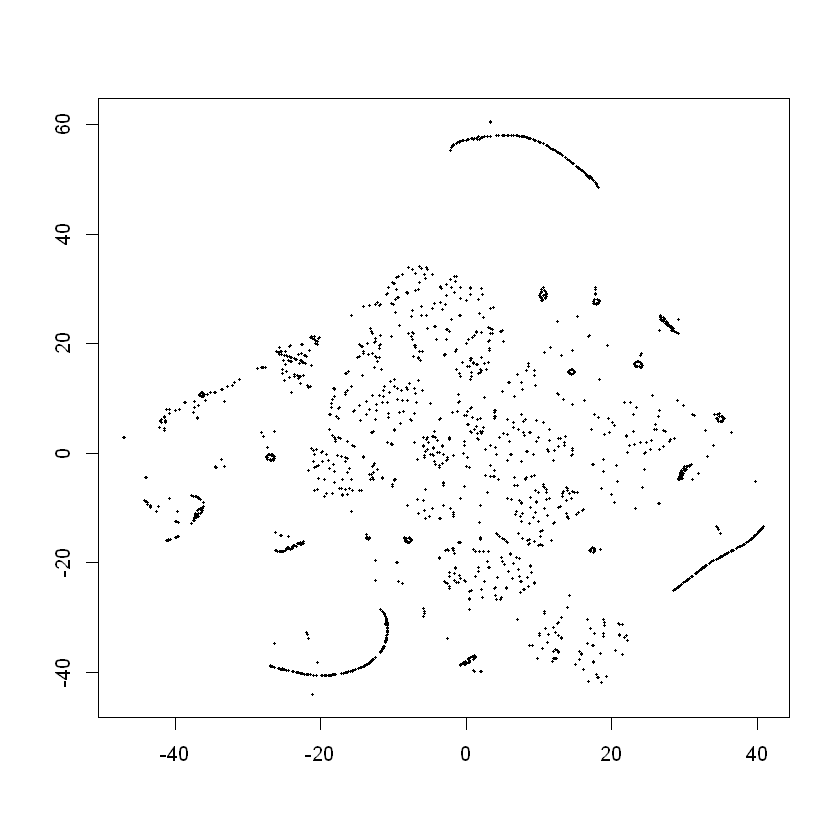

In [22]:
## Attempt 1: The whole data as initially:

So1 <- tapply(data$id.orig_h, data$id.orig_h)
De1 <- tapply(data$id.resp_h, data$id.resp_h)
Est <- as.matrix(cbind(So1, De1))
M<- sparseMatrix(i=Est[,1], j=Est[,2])

d <- 17		## Number of dimensions
SVD <- irlba(M, nv=d)
Y <- SVD$v %*% diag(sqrt(SVD$d))	
X = SVD$u %*% diag(sqrt(SVD$d))		## Embedding for the source computers	

tsne_out.1 <- Rtsne(Y,dim = 2, check_duplicates=FALSE)
# png("Cluster_attempt_1.png")
plot(tsne_out.1$Y, pch=16, cex=.3, ann=FALSE, main = "Basic cluster")
# dev.off()

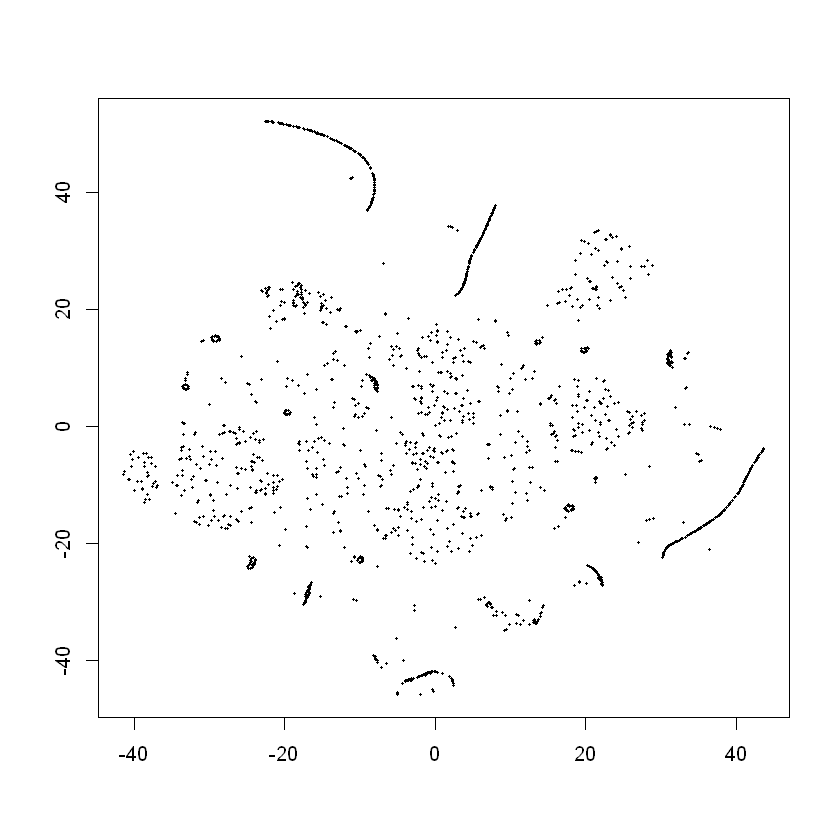

In [23]:
## Attempt 2: The data.bad - with mean imputation replacing NAs:

So1 <- tapply(data.bad$id.orig_h, data.bad$id.orig_h)
De1 <- tapply(data.bad$id.resp_h, data.bad$id.resp_h)
Est <- as.matrix(cbind(So1, De1))
M<- sparseMatrix(i=Est[,1], j=Est[,2])

d <- 17		## Number of dimensions
SVD <- irlba(M, nv=d)
Y <- SVD$v %*% diag(sqrt(SVD$d))	
X = SVD$u %*% diag(sqrt(SVD$d))		## Embedding for the source computers	

tsne_out.2 <- Rtsne(Y, check_duplicates=FALSE)
# png("Cluster_attempt_2.png")
plot(tsne_out.2$Y, pch=16, cex=.3, ann=FALSE, main = "Mean imputed cluster")
# dev.off()

[1] 226943     15

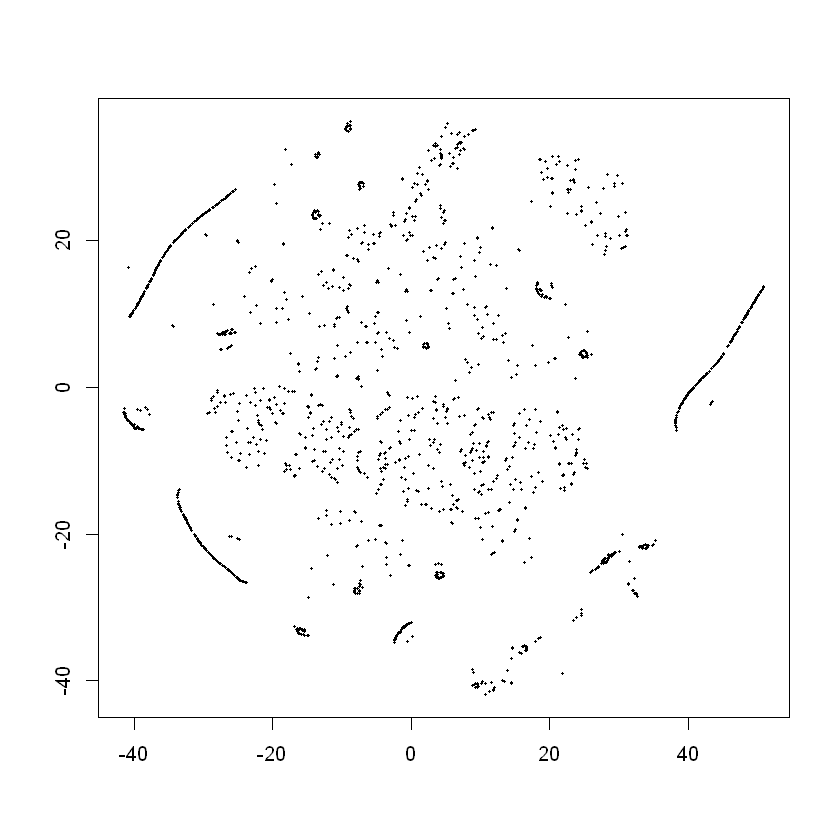

In [24]:
## Attempt 3: The data with NAs replaced by binary counterpart
newdata<- data
newdata<- newdata[, -(8:10)]
newdata<- cbind(newdata, miss.me)
dim(newdata) # 17-3+1 = 15 features

So1 <- tapply(newdata$id.orig_h, newdata$id.orig_h)
De1 <- tapply(newdata$id.resp_h, newdata$id.resp_h)
Est <- as.matrix(cbind(So1, De1))
M<- sparseMatrix(i=Est[,1], j=Est[,2])

d <- 15		## Number of dimensions
SVD <- irlba(M, nv=d)
Y <- SVD$v %*% diag(sqrt(SVD$d))	
X = SVD$u %*% diag(sqrt(SVD$d))		## Embedding for the source computers	

tsne_out.3 <- Rtsne(Y, check_duplicates=FALSE)
# png("Cluster_attempt_3.png")
plot(tsne_out.3$Y, pch=16, cex=.3, ann=FALSE, main = "NA removed cluster")
# dev.off()

While no. 1 and no. 2 are mostly indistinguishable, except for the arbitrary starting point of the cluster;
no. 3 has fewer dimensions to work with. Due to our KNN analysis, however, we knew to expect no. 3 to have very
similar results to the previous clusterings nonetheless. We can have a more thorough look at the clusters:

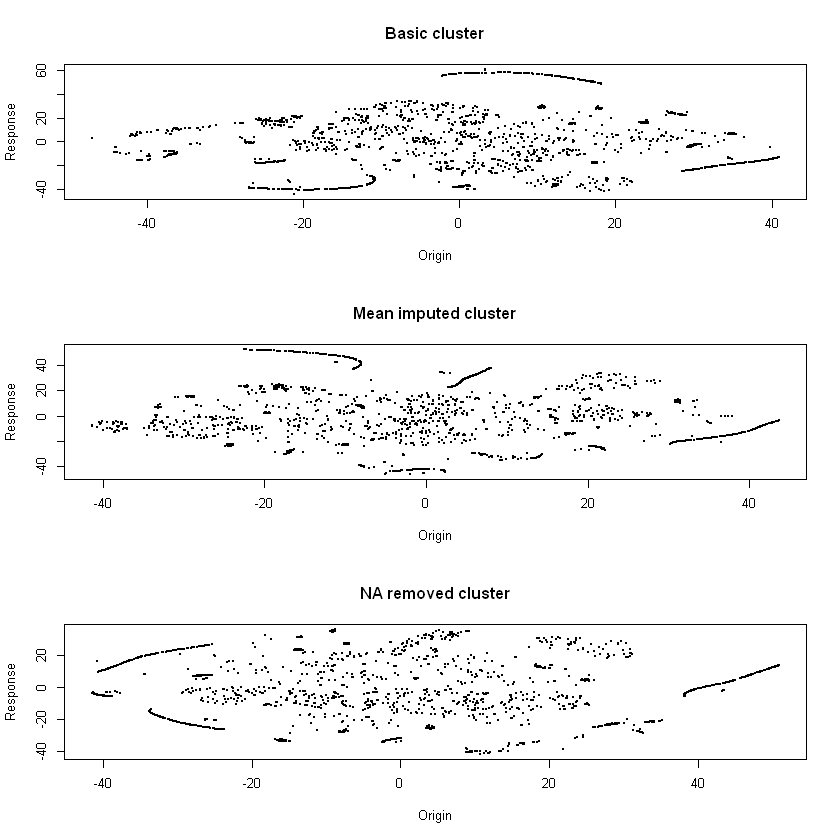

In [26]:
# png("Three_clusters_points.png")
op<- par(mfrow=c(3,1))
plot(tsne_out.1$Y, pch=16, cex=.3, ann = TRUE,
xlab="Origin", ylab = "Response", main = "Basic cluster")
plot(tsne_out.2$Y, pch=16, cex=.3, ann = TRUE,
xlab="Origin", ylab = "Response", main = "Mean imputed cluster")
plot(tsne_out.3$Y, pch=16, cex=.3, ann = TRUE,
xlab="Origin", ylab = "Response", main = "NA removed cluster")
par(op)
# dev.off()

An even more advanced analysis:

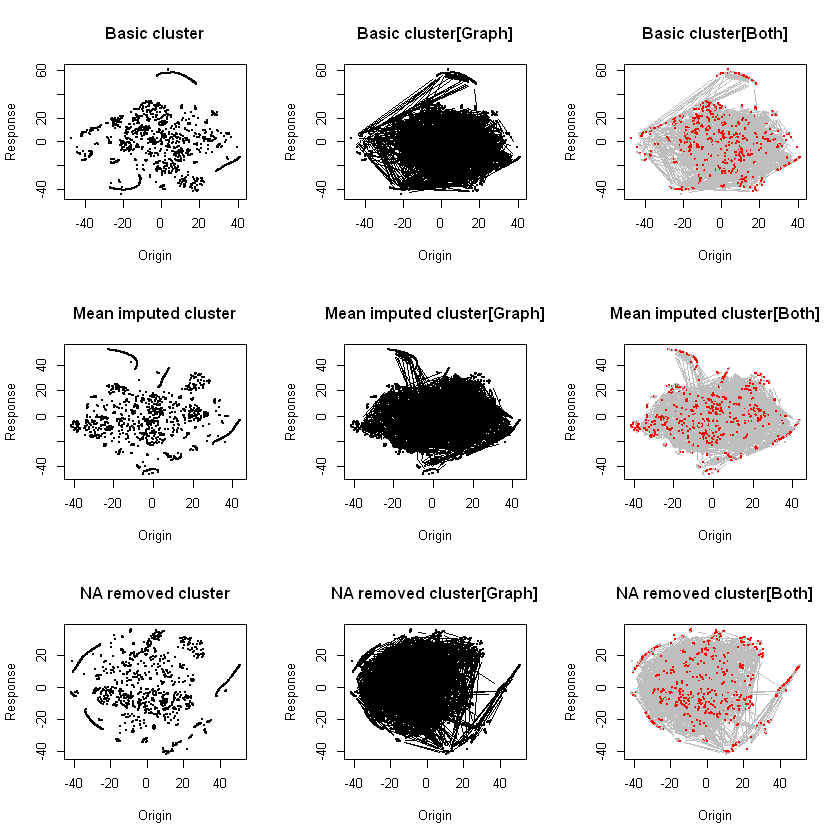

In [28]:
# png("All_clusters.png")
op1<- par(mfrow=c(3,3))
plot(tsne_out.1$Y, pch=16, cex=.3, ann = TRUE,
xlab="Origin", ylab = "Response", main = "Basic cluster")
plot(tsne_out.1$Y, pch=16, cex=.3, ann = TRUE, type="b",
xlab="Origin", ylab = "Response", main = "Basic cluster[Graph]")
plot(tsne_out.1$Y, pch=16, cex=.3, ann = TRUE, type="b", col= c("grey", "red"),
xlab="Origin", ylab = "Response", main = "Basic cluster[Both]")

plot(tsne_out.2$Y, pch=16, cex=.3, ann = TRUE,
xlab="Origin", ylab = "Response", main = "Mean imputed cluster")
plot(tsne_out.2$Y, pch=16, cex=.3, ann = TRUE, type="b",
xlab="Origin", ylab = "Response", main = "Mean imputed cluster[Graph]")
plot(tsne_out.2$Y, pch=16, cex=.3, ann = TRUE, type="b", col=c("grey", "red"),
xlab="Origin", ylab = "Response", main = "Mean imputed cluster[Both]")

plot(tsne_out.3$Y, pch=16, cex=.3, ann = TRUE,
xlab="Origin", ylab = "Response", main = "NA removed cluster")
plot(tsne_out.3$Y, pch=16, cex=.3, ann = TRUE, type="b",
xlab="Origin", ylab = "Response", main = "NA removed cluster[Graph]")
plot(tsne_out.3$Y, pch=16, cex=.3, ann = TRUE, type="b", col=c("grey", "red"),
xlab="Origin", ylab = "Response", main = "NA removed cluster[Both]")
par(op1)
# dev.off()

The existence of external connections to what we assume to be the main operating server(s) is evident. While this pushes us to pursue the issue further later on, for now, we conclude that it is not very useful in determining the aspect of missingness in 'duration' and the other 2 related features. While a remarkable result, it offers little to no continuity in this form.

**Attempt 2**

The advantage of the previous method, which is mostly a result of the packages used, was that it allowed for non-numerical parameters. However, we constructed the 'data.good' dataset for a reason - we intend to use it for our 2nd attempt at constructing useful clusters to visualise datapoints. It will easily become visually apparent why this approach is better suited for our needs. We will be testing for 4 different values of K: {5,10,15,20}:

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 11347150)"

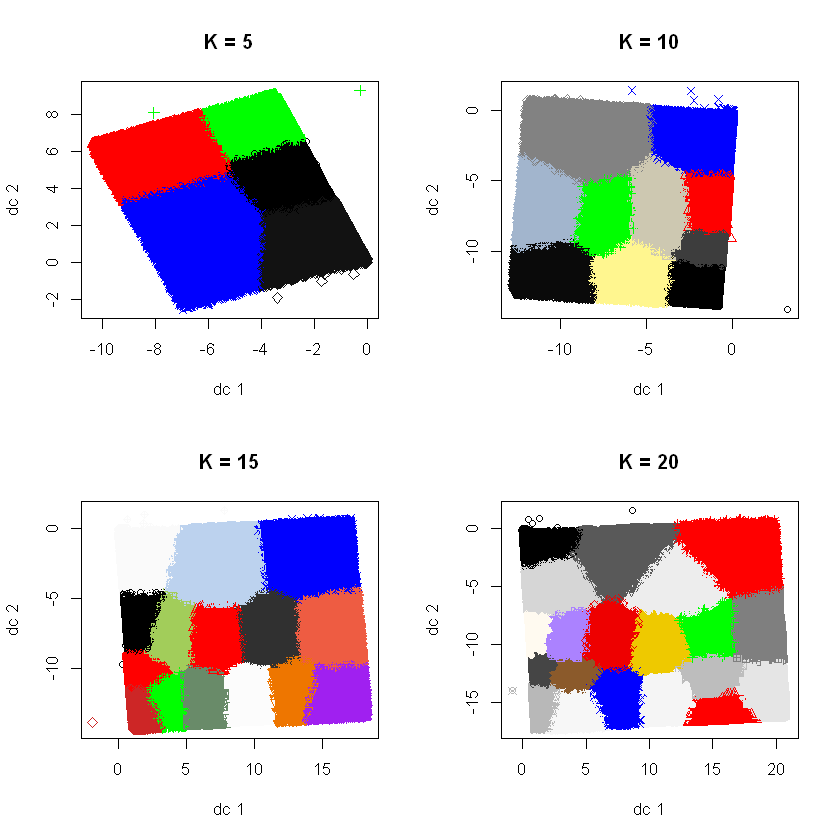

In [32]:
# png("K-means_Attempts.png")
op2<- par(mfrow = c(2,2))
clus1 <- kmeans(data.good, centers = 5)
plotcluster(data.good, clus1$cluster, pch = clus1$cluster, main = "K = 5")
clus2 <- kmeans(data.good, centers = 10)
plotcluster(data.good, clus2$cluster, pch = clus2$cluster, main = "K = 10")
clus.good <- kmeans(data.good, centers = 15)
plotcluster(data.good, clus.good$cluster, pch = clus.good$cluster, main = "K = 15")
clus3 <- kmeans(data.good, centers = 20)
plotcluster(data.good, clus3$cluster, pch = clus3$cluster, main = "K = 20")
par(op2)
# dev.off()

 We've decided to work with K = 15 for 2 main reasons:
 
i) It's around the highest number of clusters where the code doesn't break - i.e. the plot functions as intended and it
is able to assign (roughly) all datapoints to a corresponding cluster, whereas from k=20 onwards it often fails to do so (though in our visualisation it did not this time) and 

ii) It's close to the 2*dim() threshold suggested in the literature, which in our case would be 2 * 7=14.

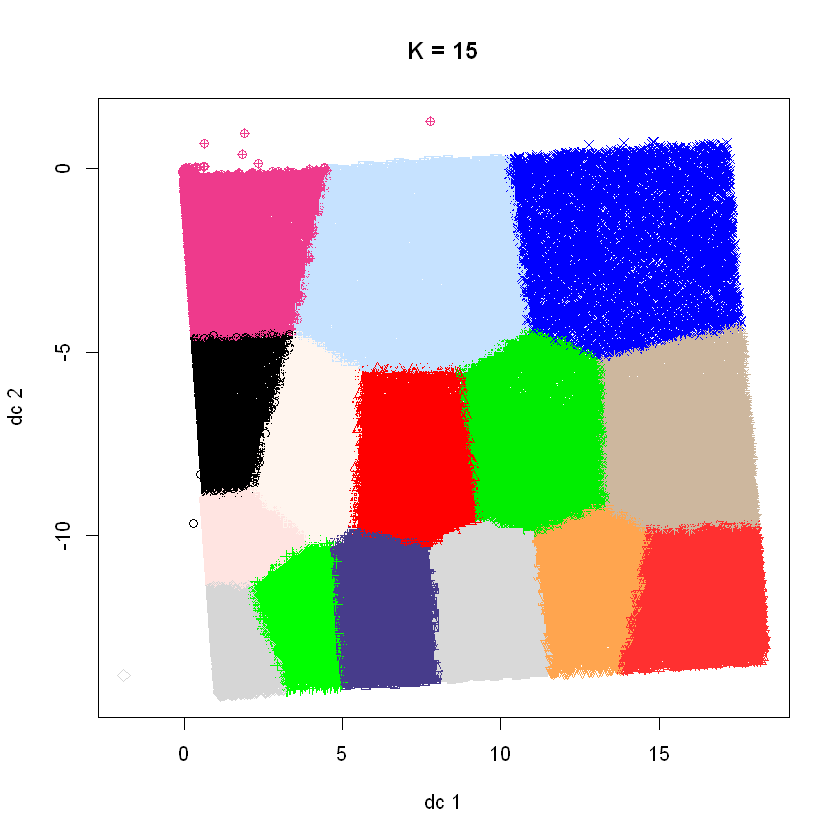

In [33]:
# png("Bus_Seat.png")
plotcluster(data.good, clus.good$cluster, pch = clus.good$cluster, main = "K = 15")
# dev.off()

Before proceeding, this is the best time to see what the non-trivial model chosen - DBScan clustering - has achieved on the same features (and 3 more, added for more accuracy). The following results will only be shown as they are plotted, but the entire history of their respective analysis can be found (as linked earlier at the start) in my colleague's individual folders: [here for Matt's](https://github.com/mc17336/DST-Assessment-2/tree/main/Matt%20Corrie) and [here for Wenqi's](https://github.com/mc17336/DST-Assessment-2/tree/main/Wenqi%20Fang):

Matt obtained the following:

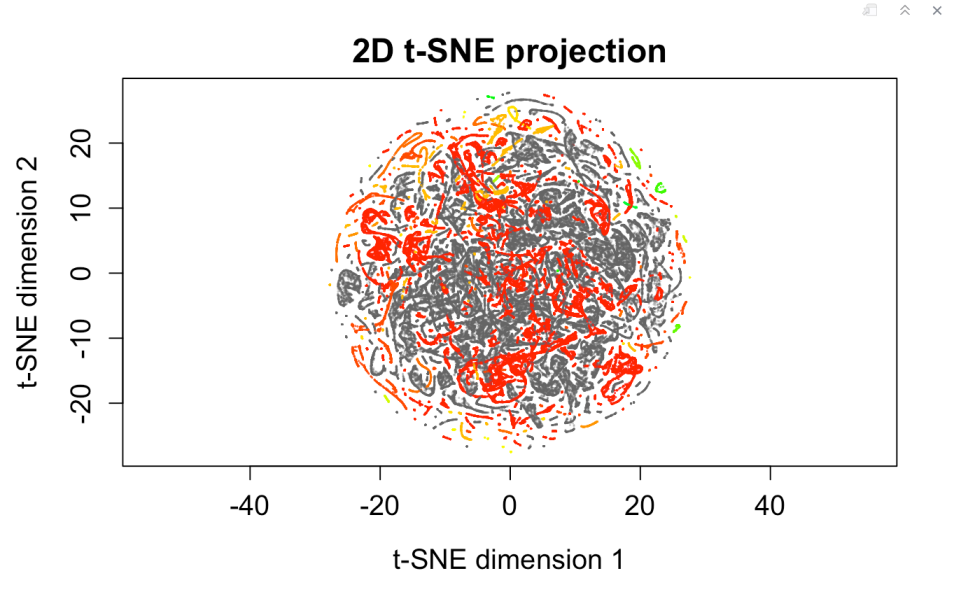

After applying a different mapping, he obtained a more organized image of the same cluster:

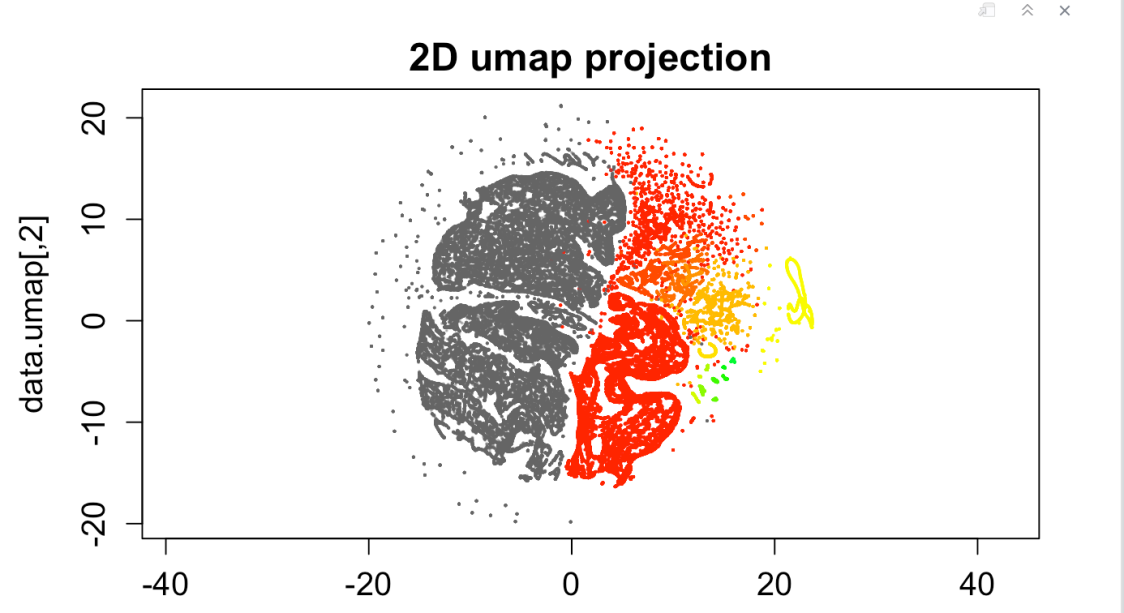

Wenqi obtained the following, also using DBScan on a different package:

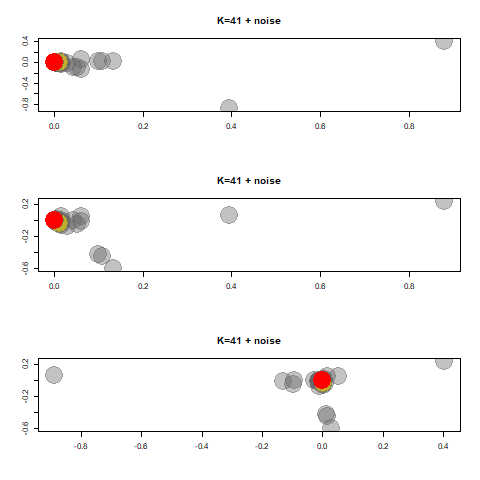

It is already apparent that the method of clustering differs massively and so do the results. DBScan seems to assign massive credit to a single cluster, perhaps corresponding to the source(s), and presents more unassigned values than our K-means clusters. This is an already alarming indicator of the end-results for the non-trivial model.

We can now start the enrichment procedure attempt.

## Using our best cluster to reconstruct the missing data

Like we previously said, we've chosen the cluster on 15-means for reasons already stated. We'll now attempt the reconstruction procedure:

In [35]:
clus <- clus.good
    ## We want to check if our cluster's length matches the data accordingly
identical(length(clus$cluster), nrow(data))
Cluster_Assignment <- clus$cluster

[1] TRUE

We want to use a trick of adding an extra column to our data which we'll use for ordering it back to normal after our procedure - since we'll be splitting it in 15 disjoint subsets, each representing a cluster. We'll properly call the column 'Keep_Me':

In [36]:
data <- cbind(data, Cluster_Assignment)
data<- cbind(data, Keep_Me = c(1:nrow(data)))

Now to split the data

In [37]:
df1 <- data[data$Cluster_Assignment==1, ]
df2 <- data[data$Cluster_Assignment==2, ]
df3 <- data[data$Cluster_Assignment==3, ]
df4 <- data[data$Cluster_Assignment==4, ]
df5 <- data[data$Cluster_Assignment==5, ]
df6 <- data[data$Cluster_Assignment==6, ]
df7 <- data[data$Cluster_Assignment==7, ]
df8 <- data[data$Cluster_Assignment==8, ]
df9 <- data[data$Cluster_Assignment==9, ]
df10 <- data[data$Cluster_Assignment==10, ]
df11 <- data[data$Cluster_Assignment==11, ]
df12 <- data[data$Cluster_Assignment==12, ]
df13 <- data[data$Cluster_Assignment==13, ]
df14 <- data[data$Cluster_Assignment==14, ]
df15 <- data[data$Cluster_Assignment==15, ]

We'll consider 3 vectors: m,n and l - capturing the mean duration, orig_bytes and resp_bytes respectively for each of the clusters. This way, we'll be able to reconstruct the data just like we did with the mean imputation earlier in the paper - except much more accurate due to the classifying properties of the clusters:

In [39]:
m<- vector(length = 15)
m[1]<- mean(df1$duration, na.rm = TRUE)
m[2]<- mean(df2$duration, na.rm = TRUE)
m[3]<- mean(df3$duration, na.rm = TRUE)
m[4]<- mean(df4$duration, na.rm = TRUE)
m[5]<- mean(df5$duration, na.rm = TRUE)
m[6]<- mean(df6$duration, na.rm = TRUE)
m[7]<- mean(df7$duration, na.rm = TRUE)
m[8]<- mean(df8$duration, na.rm = TRUE)
m[9]<- mean(df9$duration, na.rm = TRUE)
m[10]<- mean(df10$duration, na.rm = TRUE)
m[11]<- mean(df11$duration, na.rm = TRUE)
m[12]<- mean(df12$duration, na.rm = TRUE)
m[13]<- mean(df13$duration, na.rm = TRUE)
m[14]<- mean(df14$duration, na.rm = TRUE)
m[15]<- mean(df15$duration, na.rm = TRUE)
invisible(m)

n<- vector(length = 15)
n[1]<- mean(df1$orig_bytes, na.rm = TRUE)
n[2]<- mean(df2$orig_bytes, na.rm = TRUE)
n[3]<- mean(df3$orig_bytes, na.rm = TRUE)
n[4]<- mean(df4$orig_bytes, na.rm = TRUE)
n[5]<- mean(df5$orig_bytes, na.rm = TRUE)
n[6]<- mean(df6$orig_bytes, na.rm = TRUE)
n[7]<- mean(df7$orig_bytes, na.rm = TRUE)
n[8]<- mean(df8$orig_bytes, na.rm = TRUE)
n[9]<- mean(df9$orig_bytes, na.rm = TRUE)
n[10]<- mean(df10$orig_bytes, na.rm = TRUE)
n[11]<- mean(df11$orig_bytes, na.rm = TRUE)
n[12]<- mean(df12$orig_bytes, na.rm = TRUE)
n[13]<- mean(df13$orig_bytes, na.rm = TRUE)
n[14]<- mean(df14$orig_bytes, na.rm = TRUE)
n[15]<- mean(df15$orig_bytes, na.rm = TRUE)
invisible(n)

l <- vector(length = 15)
l[1]<- mean(df1$resp_bytes, na.rm = TRUE)
l[2]<- mean(df2$resp_bytes, na.rm = TRUE)
l[3]<- mean(df3$resp_bytes, na.rm = TRUE)
l[4]<- mean(df4$resp_bytes, na.rm = TRUE)
l[5]<- mean(df5$resp_bytes, na.rm = TRUE)
l[6]<- mean(df6$resp_bytes, na.rm = TRUE)
l[7]<- mean(df7$resp_bytes, na.rm = TRUE)
l[8]<- mean(df8$resp_bytes, na.rm = TRUE)
l[9]<- mean(df9$resp_bytes, na.rm = TRUE)
l[10]<- mean(df10$resp_bytes, na.rm = TRUE)
l[11]<- mean(df11$resp_bytes, na.rm = TRUE)
l[12]<- mean(df12$resp_bytes, na.rm = TRUE)
l[13]<- mean(df13$resp_bytes, na.rm = TRUE)
l[14]<- mean(df14$resp_bytes, na.rm = TRUE)
l[15]<- mean(df15$resp_bytes, na.rm = TRUE)
invisible(l)

In [44]:
k <- kable(cbind(Mean.duration =m,Mean.orig_bytes = n,Mean.resp_bytes=l)) 
k



| Mean.duration| Mean.orig_bytes| Mean.resp_bytes|
|-------------:|---------------:|---------------:|
|     3.8681804|    9.091049e+05|      503.239643|
|     0.0716209|    4.862840e-02|        0.000000|
|     0.1835704|    3.258597e+01|      162.777886|
|     0.1856540|    0.000000e+00|        2.436026|
|     3.3352178|    5.605239e+05|     1253.569992|
|     0.4087735|    2.540644e+00|        0.999038|
|     0.1720030|    0.000000e+00|        0.000000|
|     0.1244090|    5.775436e-01|        3.517616|
|     2.3178689|    8.808118e+05|      874.432078|
|     4.6289077|    8.346194e+05|     4309.266239|
|     0.0680368|    1.299499e+00|        9.459482|
|     0.2912990|    2.528534e+01|      123.778512|
|     0.0589118|    9.163803e-01|        2.090874|
|     0.0729072|    2.567010e-01|        0.000000|
|     0.1480985|    6.647790e+00|        0.000000|

These are our results. Notably, K-means successfully managed to avoid getting any cluster consisting only of NAs. This is a thrilling result, as it means that our reconstruction/enrichment will be successful - and none of the splits will be left aside. Moreover, there is a pragmatic correlation among the reconstructed values: Whenever the orig_bytes and the resp_bytes present really high values, there is a response not only among each other, but often also in the duration - for example see cluster #1 or #5 -- where this property is most tangible.

We are now left to combine the values in our partitioned datasets, then bring them all back together:

In [45]:
for(i in 1:nrow(df1)) {
	if(is.na(df1$duration[i])) {
		df1$duration[i] <- m[1] }
	if(is.na(df1$orig_bytes[i])) {
		df1$orig_bytes[i] <- n[1] }
	if(is.na(df1$resp_bytes[i])) {
		df1$resp_bytes[i] <- l[1] }
	}
for(i in 1:nrow(df2)) {
	if(is.na(df2$duration[i])) {
		df2$duration[i] <- m[2] }
	if(is.na(df2$orig_bytes[i])) {
		df2$orig_bytes[i] <- n[2] }
	if(is.na(df2$resp_bytes[i])) {
		df2$resp_bytes[i] <- l[2] }
	}
for(i in 1:nrow(df3)) {
	if(is.na(df3$duration[i])) {
		df3$duration[i] <- m[3] }
	if(is.na(df3$orig_bytes[i])) {
		df3$orig_bytes[i] <- n[3] }
	if(is.na(df3$resp_bytes[i])) {
		df3$resp_bytes[i] <- l[3] }
	}
for(i in 1:nrow(df4)) {
	if(is.na(df4$duration[i])) {
		df4$duration[i] <- m[4] }
	if(is.na(df4$orig_bytes[i])) {
		df4$orig_bytes[i] <- n[4] }
	if(is.na(df4$resp_bytes[i])) {
		df4$resp_bytes[i] <- l[4] }
	}
for(i in 1:nrow(df5)) {
	if(is.na(df5$duration[i])) {
		df5$duration[i] <- m[5] }
	if(is.na(df5$orig_bytes[i])) {
		df5$orig_bytes[i] <- n[5] }
	if(is.na(df5$resp_bytes[i])) {
		df5$resp_bytes[i] <- l[5] }
	}
for(i in 1:nrow(df6)) {
	if(is.na(df6$duration[i])) {
		df6$duration[i] <- m[6] }
	if(is.na(df6$orig_bytes[i])) {
		df6$orig_bytes[i] <- n[6] }
	if(is.na(df6$resp_bytes[i])) {
		df6$resp_bytes[i] <- l[6] }
	}
for(i in 1:nrow(df7)) {
	if(is.na(df7$duration[i])) {
		df7$duration[i] <- m[7] }
	if(is.na(df7$orig_bytes[i])) {
		df7$orig_bytes[i] <- n[7] }
	if(is.na(df7$resp_bytes[i])) {
		df7$resp_bytes[i] <- l[7] }
	}
for(i in 1:nrow(df8)) {
	if(is.na(df8$duration[i])) {
		df8$duration[i] <- m[8] }
	if(is.na(df8$orig_bytes[i])) {
		df8$orig_bytes[i] <- n[8] }
	if(is.na(df8$resp_bytes[i])) {
		df8$resp_bytes[i] <- l[8] }
	}
for(i in 1:nrow(df9)) {
	if(is.na(df9$duration[i])) {
		df9$duration[i] <- m[9] }
	if(is.na(df9$orig_bytes[i])) {
		df9$orig_bytes[i] <- n[9] }
	if(is.na(df9$resp_bytes[i])) {
		df9$resp_bytes[i] <- l[9] }
	}
for(i in 1:nrow(df10)) {
	if(is.na(df10$duration[i])) {
		df10$duration[i] <- m[10] }
	if(is.na(df10$orig_bytes[i])) {
		df10$orig_bytes[i] <- n[10] }
	if(is.na(df10$resp_bytes[i])) {
		df10$resp_bytes[i] <- l[10] }
	}
for(i in 1:nrow(df11)) {
	if(is.na(df11$duration[i])) {
		df11$duration[i] <- m[11] }
	if(is.na(df11$orig_bytes[i])) {
		df11$orig_bytes[i] <- n[11] }
	if(is.na(df11$resp_bytes[i])) {
		df11$resp_bytes[i] <- l[11] }
	}
for(i in 1:nrow(df12)) {
	if(is.na(df12$duration[i])) {
		df12$duration[i] <- m[12] }
	if(is.na(df12$orig_bytes[i])) {
		df12$orig_bytes[i] <- n[12] }
	if(is.na(df12$resp_bytes[i])) {
		df12$resp_bytes[i] <- l[12] }
	}
for(i in 1:nrow(df13)) {
	if(is.na(df13$duration[i])) {
		df13$duration[i] <- m[13] }
	if(is.na(df13$orig_bytes[i])) {
		df13$orig_bytes[i] <- n[13] }
	if(is.na(df13$resp_bytes[i])) {
		df13$resp_bytes[i] <- l[13] }
	}
for(i in 1:nrow(df14)) {
	if(is.na(df14$duration[i])) {
		df14$duration[i] <- m[14] }
	if(is.na(df14$orig_bytes[i])) {
		df14$orig_bytes[i] <- n[14] }
	if(is.na(df14$resp_bytes[i])) {
		df14$resp_bytes[i] <- l[14] }
	}
for(i in 1:nrow(df15)) {
	if(is.na(df15$duration[i])) {
		df15$duration[i] <- m[15] }
	if(is.na(df15$orig_bytes[i])) {
		df15$orig_bytes[i] <- n[15] }
	if(is.na(df15$resp_bytes[i])) {
		df15$resp_bytes[i] <- l[15] }
	}

In [47]:
data3<- rbind(df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15)
    ## Using the 'Keep_Me' column we can now reorder the dataset to bring back the initial data
data3<- data3[order(data3$Keep_Me, decreasing = FALSE), ]
data <- data3[, -ncol(data3)]

As a final test before viewing the results, let us examine if we missed any points somehow:

In [48]:
    ## Should be TRUE
identical(rep(0, times = ncol(data)), MissVal())

[1] TRUE

We can now visualise the final result of our enrichment:

In [49]:
head(data,50)

uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,Cluster_Assignment
CHEoFb1O6PBGt1NEa7,192.168.202.110,50427,192.168.22.102,15457,tcp,-,0.07290722,2.567010e-01,0.000000,REJ,0,Sr,1,48,1,40,14
Cy6Fv76vPYfgHtCpk,192.168.202.83,46442,192.168.206.44,42,tcp,-,2.31786890,8.808118e+05,874.432078,REJ,0,Sr,1,60,1,40,9
CkpLOHhJomkmlfso3,192.168.202.110,12662,192.168.22.1,17800,tcp,-,0.17200305,0.000000e+00,0.000000,S0,0,S,1,48,0,0,7
CMQ0Qy4XI18ermMFhb,192.168.202.138,35203,192.168.24.187,10629,tcp,-,0.29129899,2.528534e+01,123.778512,S0,0,S,1,44,0,0,12
CiCXbo2GSUPiqsv2Kl,192.168.202.110,63958,192.168.22.252,56587,tcp,-,0.06803676,1.299499e+00,9.459482,S0,0,S,1,48,0,0,11
C5SBk532nTOCbdcXWf,192.168.204.45,39436,192.168.21.101,33384,tcp,-,0.05891180,9.163803e-01,2.090874,REJ,0,Sr,1,44,1,40,13
Cvtgnu3rcNc9OE5F0g,192.168.202.83,52132,192.168.206.44,32776,tcp,-,0.14809852,6.647790e+00,0.000000,REJ,0,Sr,1,60,1,40,15
CxNCZg20iY4sUIzl8d,192.168.204.45,41741,192.168.23.102,7476,tcp,-,0.29129899,2.528534e+01,123.778512,S0,0,S,1,60,0,0,12
C6iKiCA4jmAUXr4s8,192.168.202.83,40224,192.168.206.44,1688,tcp,-,3.86818037,9.091049e+05,503.239643,REJ,0,Sr,1,60,1,40,1
CotShS2qs3FeRJA2wg,192.168.202.79,63022,192.168.28.100,2010,tcp,-,3.33521784,5.605239e+05,1253.569992,S0,0,S,1,44,0,0,5


For comparison, DBScan's results were much worse due to something we observed from the clustering phase: A tendency of lapping all the NAs and outliers together. When splitting into 14 clusters, naturally, a few of those captured features which were entirely missing in the 'duration', 'orig_bytes' and 'resp_bytes' aspects - making the reconstruction return 0 for those, whereas the rest were mainly massive outliers - which resulted in entire clusters composed exclusively of outliers. This is an unfortunate result that K-means avoided by its algorithmic nature of picking a random starting point that's _necessarily a number_. This ensured that we at the very least had 1 non-missing datapoint in each cluster, as well as many more similar enough to it, and consequently the remaining datapoints got mixed in with the outliers - creating more accurate predictions than if the outliers were put aside in separate clusters:



**DBScan's final results:**

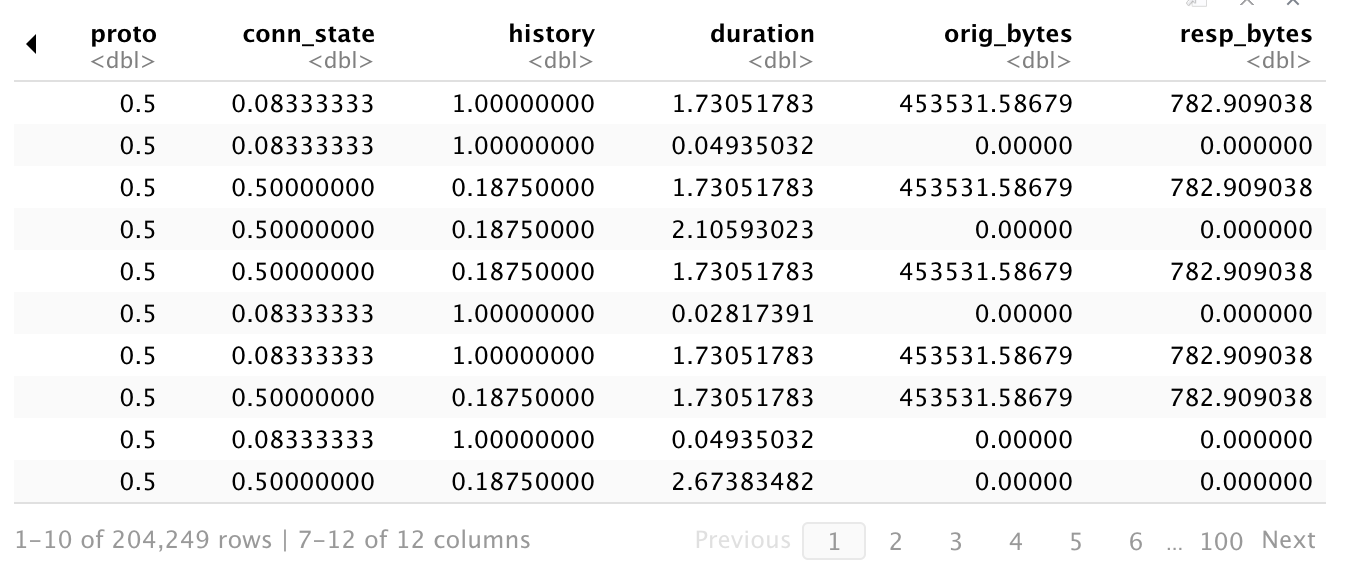

## Conclusions

The results of this analysis were truly unexpected. On the bright side, we managed to reconstruct the missing data in our set nicely, so the purpose of this inquiry has been met. However, it was done so by what we considered to be the "basic" model more than the "complex" one managed. The reasons for this conclusion became more and more apparent as we progressed through the stages of the project, but the possibility certainly eluded us at the start. Nonetheless, the enrichment has been carried out well enough for our data to be considered reconstructed, and we appreciate that a similar method could be applied to the whole, large dataset - though computational complexity and memory are bound to impede such a procedure.

## References

www.secrepo.com - For providing the initial dataset and a breakdown of multiple others

[Understanding K-means clustering](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)

[Implementing K-means clustering](https://www.datacamp.com/community/tutorials/k-means-clustering-r)

! Content only meant for UoB staff and students ! [Patrick Rubin-Delanchy's Workshop for K-means clustering](https://www.ole.bris.ac.uk/bbcswebdav/pid-4676884-dt-content-rid-16514005_2/courses/MATHM0028_2020_TB-1A/problem_class3%281%29.pdf)

[Dealing with missing data in R](https://medium.com/coinmonks/dealing-with-missing-data-using-r-3ae428da2d17)

[Implementing the kNN algorithm in R](https://towardsdatascience.com/k-nearest-neighbors-algorithm-with-examples-in-r-simply-explained-knn-1f2c88da405c)

[Used libraries and functions](https://github.com/mc17336/DST-Assessment-2/blob/main/Alex%20Caian/Libraries%20and%20FUN)





## *A bit about intrusion

_Note to reader: This segment is no longer related to the actual purpose of our inquiry, but can be run straight away as it uses the same dataset. Consider it as 'general interest'_, and no longer part of the project per se.

What if instead of inquiring about enrichment we wanted to look for potential intrusions among the connections in the set? This idea is not born out of nothingness - taking the dataset from secrepo, we know that malicious activity is certainly to be found within the whole dataset and, consequently, probably to be found in our sampled subset as well. The clusters we plotted in our first attempt also clearly indicate suspicious activity - but how would one continue pursuing this thought? I claim that by the aid of clusters we can shed some light on this issue, and other sorts of classification problems alike:



  icmp    tcp    udp 
  1746 222931   2266 


icmp  tcp  udp 
1746 1682    0 

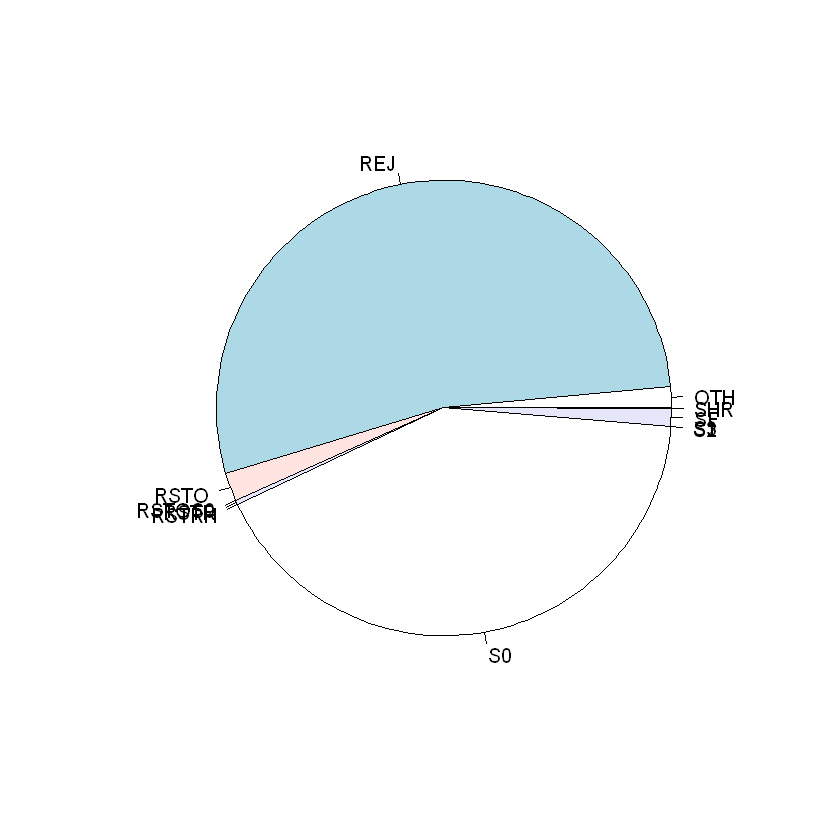

In [50]:
dOTH <- data[data$conn_state=="OTH", ]
table(data$proto)
table(dOTH$proto)	## OTH contains all icmp protocols
t<- table(data$conn_state)
pie(t, labels = names(t))	

We firstly observe that, whatever conn_states actually are, the one labeled "OTH" contains very few connections in comparison with others, yet all ICMP pings are sent from it. This is already anomalous, but perhaps even more so when put into perspective:

In [51]:
length(unique(data$id.orig_h))
table(data$id.orig_h)

[1] 189


                                  ::                              0.0.0.0 
                                  10                                    1 
                         10.10.10.10                        10.10.117.209 
                                   1                                  138 
                      128.244.37.196                         172.16.6.100 
                                   1                                    5 
                         172.16.6.57                          172.16.6.64 
                                   4                                    3 
                       192.168.202.1                      192.168.202.100 
                                  14                                  231 
                     192.168.202.101                      192.168.202.102 
                                4994                                 3248 
                     192.168.202.103                      192.168.202.106 
                        

The table above presents all unique IP addresses (or IPv6's) from which packets were sent, as well as the number of instances they present. One interesting connection is the one with IP address 0.0.0.0 : which in networks terminology stands for "non-routable meta-address used to designate an invalid, unknown or non-applicable target".

In [52]:
data[data$id.orig_h=="0.0.0.0", ]

,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,Cluster_Assignment
106124,Cx6VWm3TxKdVjpB3bh,0.0.0.0,68,255.255.255.255,67,udp,dhcp,119.45,2400,0,S0,0,D,8,2624,0,0,10


The response to it is broadcast everywhere - indicated by ip 255.255.255.255. Although a long, possibly vague shot, this instance is likely captured by our previously plotted clusters via one of the isolated points, connecting nowhere (We are here referring to our 1st attempt at clustering, not the 2nd one - where point connections are of no relevance due to the way of visualising).

We recognize 4 main conn_states: S0, S1, S2 and S3 : Although most of the connections seem to be transmitted from 'S0' and 'REJ', rather than any of the others: 

In [53]:
length(data$conn_state[data$conn_state=="S0"]) # 94740
length(data$conn_state[data$conn_state=="REJ"]) # 120526

[1] 94740

[1] 120526

Judging by our table, we would expect these to almost account for all the connections coming from the "home" server - i.e. that with the masked IP starting in 192.168. We can isolate it and test our hypothesis by slowly eliminating states:

In [54]:
S0 <- data[data$conn_state=="S0", ]
h <- grep("192.168", S0$id.orig_h)
S0.bad <- S0[-h, ]
q <- grep(":", S0.bad$id.orig_h)
S0.bad2 <- S0.bad[-q, ]
dim(S0.bad2) # 147 observations - most from 10.10

[1] 147  18

Our new 'So.bad2' - which no longer contains any 192.168 transmissions has most of its packets sent from what we assume to be the other main server, as with usual notation starting with 10.10.

In [55]:
Tdata<- data[data$id.orig_h=="10.10.117.209", ]
dim(Tdata)

[1] 138  18

The rest of 147-138=9 IPs can be written off as outliers - but they're probably what we'd be looking for in selecting intrusions. Moreover, oddly enough, the other IP corresponding to our proposed server #2 - meaning 10.10.10.10 does **not** originate from S0. It's instead coming from the conn_state of 'OTH', the one sending all ICMP pings.

All these observations are a manual route towards tackling the problem of intrusion detection in our dataset. They represent a guide for any reader who wishes to further this inquiry. However, the point of this section was not to arbitrarily bring a second problem into discussion - but to extend the use of clustering. Instead of manually dissecting the dataset like we did, one may apply a method very similar to what we used for reconstructing the dataset in order to classify the points and detect outliers.

One way of doing so is via looking at the 'id_parents' hosting and responding - and clustering over those. This results in what I believe is a magnificent picture of packets transmission, and a great starting point for another project which uses the tool of cluster classification:

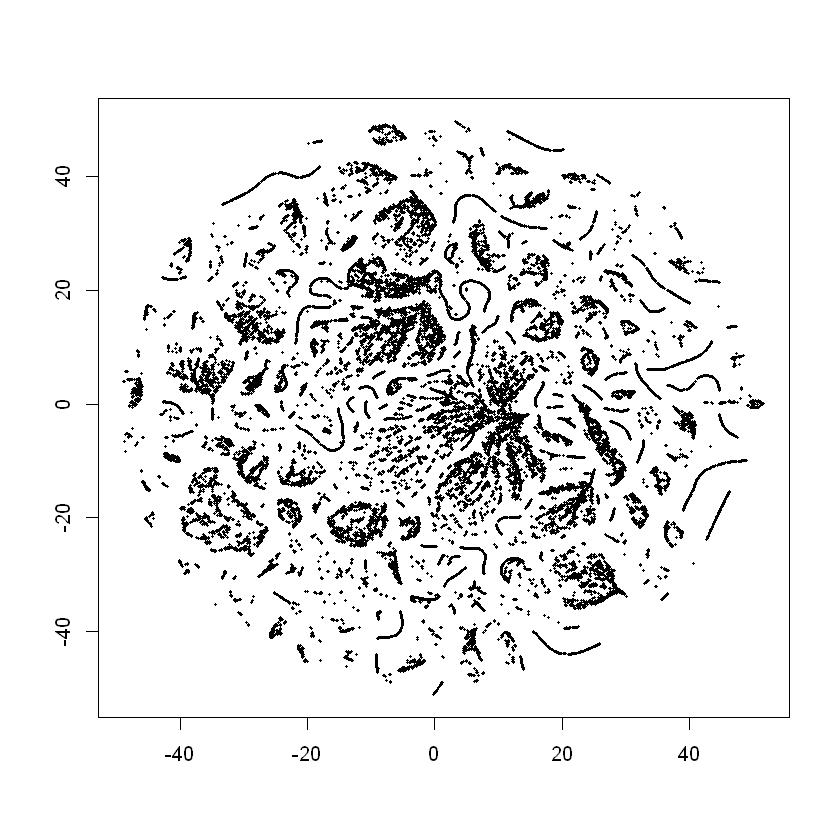

In [56]:
So1 <- tapply(data.good$id.orig_p, data.good$id.orig_p)
De1 <- tapply(data.good$id.resp_p, data.good$id.resp_p)
Est <- as.matrix(cbind(So1, De1))
M<- sparseMatrix(i=Est[,1], j=Est[,2])

d <- 7		## Number of dimensions
SVD <- irlba(M, nv=d)
Y <- SVD$v %*% diag(sqrt(SVD$d))	
X = SVD$u %*% diag(sqrt(SVD$d))		## Embedding for the source computers	

tsne_out <- Rtsne(Y, check_duplicates=FALSE)
# png("Cluster_parents.png")
plot(tsne_out$Y, pch=16, cex=.3, ann=FALSE)
# dev.off()